In [1]:
"""
TO DO
add tokens <sos> <eos> <unk>
lema stema?
size of vocab for czech language?
"""

'\nTO DO\nadd tokens <sos> <eos> <unk>\nlema stema?\nsize of vocab for czech language?\n'

In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np

import pandas as pd
pd.set_option('max_colwidth', 200)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import re
import json_lines
import pickle

from model import *

Using TensorFlow backend.


In [4]:
""" dict values: abstract, dataset, filename, headline, length, md5, offset, published, section, subdomain, text """
st = time.time()
data = []
selected_columns = ["abstract", "text"]

for dataset in ["dev"]:
    with json_lines.open(f"dataset/sumeczech-1.0-{dataset}.jsonl", 'r') as json_data:
        for line in json_data:
            data.append(line)
        if dataset == "dev": val = pd.DataFrame(data); val = val[selected_columns]
        elif dataset == "oodtest": ood_test = pd.DataFrame(data); ood_test = ood_test[selected_columns]
        elif dataset == "test": test = pd.DataFrame(data); test = test[selected_columns]
        elif dataset == "train": train = pd.DataFrame(data); train = train[selected_columns]
del data
time.time() - st

2.245940923690796

start = time.time()
#creating a dictionary from train
word_dict = {}
reg = r"[\w]+"

for i in range(train.shape[0]):
    for word in re.findall(reg, train.iloc[i]['text']) + re.findall(reg, train.iloc[i]['abstract']):
        word = word.lower()

        if word not in word_dict.keys(): word_dict[word] = 0

        word_dict[word] += 1

vocab_size = 50000

word_dict = {k : v for k, v in sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[:vocab_size]} #sorting keys by count of occurences 
for i, (word, _) in enumerate(word_dict.items()): word_dict[word] = i + 1 + 4 #replacing count values by unique token values
#special tokens
word_dict["<sos>"] = 1 #!later used in model
word_dict["<eos>"] = 2
word_dict["<unk>"] = 3
word_dict["<pad>"] = 0 #4?

with open('word_dict.pickle', 'wb') as f:
    pickle.dump(word_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

time.time() - start

In [5]:
with open('word_dict.pickle', 'rb') as f:
    word_dict = pickle.load(f)

## Determining lengths of input and output sequences (Tx and Ty)

In [ ]:
text_lens = []
abstract_lens = []

for i in range(val.shape[0]):
    text_lens.append(len(re.findall(r"[\w]+",val.iloc[i]['text'])))
    abstract_lens.append(len(re.findall(r"[\w]+", val.iloc[i]['abstract'])))

(0, 2000)

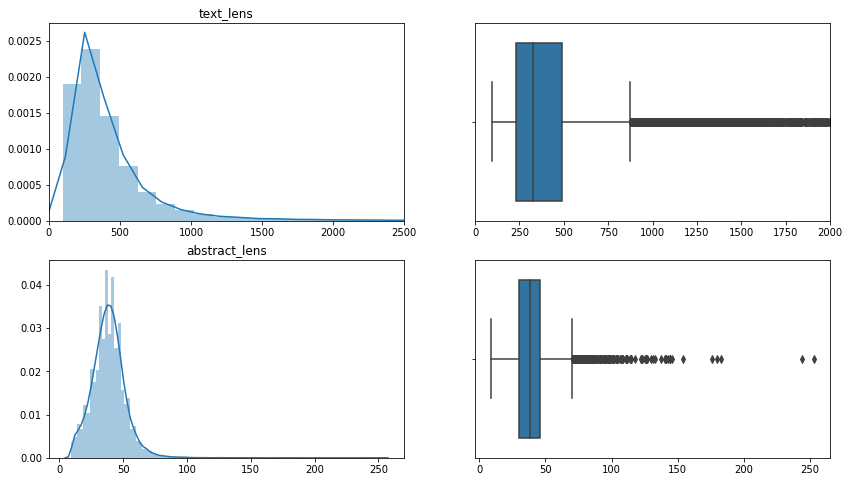

In [54]:
fig, ax = plt.subplots(2,2, figsize=(14, 8))
sns.distplot(text_lens, bins=100, ax=ax[0, 0])
sns.distplot(abstract_lens, bins=100, ax=ax[1, 0])

sns.boxplot(text_lens, ax=ax[0, 1])
sns.boxplot(abstract_lens, ax=ax[1, 1])

ax[0, 0].set_title("text_lens")
ax[1, 0].set_title("abstract_lens")

ax[0, 0].set_xlim([0, 2500])
ax[0, 1].set_xlim([0, 2000])

In [57]:
print(f"median text len: {text_lens[len(text_lens) // 2]}")
print(f"median abstract len: {abstract_lens[len(abstract_lens) // 2]}")

median text len: 334
median abstract len: 48


## Training

In [7]:
def one_hot_lookup(seq): #converts one text
    X = np.zeros((len(seq), dict_size))

    for i, x in enumerate(seq):
        X[i, x] = 1
    return X

def indexes_to_ohe(texts):
    A = np.zeros((texts.shape[0], texts.shape[1], VOCAB_SIZE))

    for i, text_indexes in enumerate(texts):
        for j, index in enumerate(text_indexes):
            A[i, j, index] = 1


def text_to_indexes(s, max_len): #converts one text ot series of indexes from range 0 - vocab_size
    s = s.lower()
    words = re.findall(r"[\w]+", s)
    encoded_words = []
    i = 0

    while i < max_len - 1: #one less because of pad token
        if i < len(words):
            word = words[i]
            try: encoded_words.append(word_dict[word])
            except: encoded_words.append(word_dict["<unk>"])
        
        else: encoded_words.append(word_dict["<pad>"])
        i += 1

    return encoded_words + [word_dict["<eos>"]]


def dataset_to_indexes(texts, max_len): #calls text_to_indexes on eache datapoint and creates np array of shape examples x max_len
    A = np.empty((len(texts), max_len))
    A = A.astype('int32')
    
    for i, text in enumerate(texts):
        A[i] = text_to_indexes(text, max_len)
    return A


In [8]:
def create_batches(x, y):
    assert x.shape[0] == x.shape[0]
    
    batches = []
    n_batches = x.shape[0] // BATCH_SIZE

    for i in range(n_batches):
        batch_x = x[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        batch_y = y[i * BATCH_SIZE:(i + 1) * BATCH_SIZE]
        batches.append((batch_x, batch_y))
    
    return batches

In [9]:
val.shape

(44566, 2)

In [ ]:
""" 
Ideas:
try shorter input seq if attention over words is not enough
add attention over sentences

Notes:
dimensions batch x examples x features
"""

In [11]:
#constants
BATCH_SIZE = 64
EPOCHS = 1
Tx = 600 #length of input sequence (article)
Ty = 60 #length of output sequence (abstract)
VOCAB_SIZE = 50000


In [30]:
X_train = dataset_to_indexes(train['text'], Tx)
Y_train = dataset_to_indexes(train['abstract'], Ty)
del train
X_val = dataset_to_indexes(val['text'], Tx)
Y_val = dataset_to_indexes(val['abstract'], Ty)
del val

In [ ]:
train = create_batches(X_train, Y_train) 
del X_Train; del Y_train
val =  create_batches(X_val, Y_val)
del X_train; del(Y_train)

In [12]:
X_train = dataset_to_indexes(val['text'], Tx)
y_train = dataset_to_indexes(val['abstract'], Ty)

In [13]:
train = create_batches(X_train, y_train)

In [17]:
model = TextSummarizer(Tx, Ty, BATCH_SIZE, VOCAB_SIZE, 
                        embedding_dim=200, a_units=32, h_units=32)

ValueError: Please initialize `Bidirectional` layer with a `Layer` instance. You passed: <keras.layers.recurrent.LSTM object at 0x7efc4a62fd10>

In [16]:
model.fit(train, EPOCHS)

AttributeError: in converted code:
    relative to /home/wenceslai:

    wenceslai_dev/soc_nlp/model.py:90 train_step  *
        a = self.encoder(X)
    anaconda3/envs/tf/lib/python3.7/site-packages/keras/engine/base_layer.py:409 __call__  *
        with K.name_scope(self.name):

    AttributeError: 'Encoder' object has no attribute 'name'
